In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from splinter import Browser
from webdriver_manager.chrome import ChromeDriverManager
import time
import re
import random
from datetime import datetime
import math
import matplotlib.pyplot as plt

In [ ]:
#####CREATE WEB-SCRAPING BOT##########

In [709]:
#opens NYTimes
def open_nytimes():
    browser.visit("https://nytimes.com")

In [710]:
#finds the search icon on the opening page and clicks it
def click_search_icon():
    buttons = browser.find_by_tag('button')

    for button in buttons:
        if (button.value=="SEARCH"):
            button.click()
            break

In [711]:
#fills in the search bar
def enter_text(search_word):

    browser.find_by_tag('input').fill(search_word)

In [712]:
#finds the 'Go' button and clicks it to start search
def click_go():
    buttons = browser.find_by_tag('button')
    #the 'Go' button is the +1 after the search icon
    found = False 

    for button in buttons:
        if (found):
            button.click()
            break
        if (button.value=="SEARCH"):
            found = True

In [713]:
#return updated html
def get_updated_html():
    thesoup=parser(browser.html)
    thesoup = BeautifulSoup(browser.html, 'html.parser')

    return thesoup

In [714]:
#function to click 'show more'
def show_more ():
    if(browser.is_element_not_present_by_text('Show More')):
        return True
    else:
        browser.find_by_text('Show More').click()
        return False
    

In [718]:
#function to pull article data
def get_article_data(soup):
    thelinks=soup.find_all(href=True)

    for link in thelinks:
        
        #makes sure is article rather than a podcast or video, based on link convention
        if(re.search(r'^/\d\d\d\d/\d\d/\d\d/', link['href'])):
            
            #makes sure not already entered into database
            if (link['href'] not in articles):
                
                #extracts the date from the link
                temp=link['href'].split('/')
                dates.append(temp[2] + '/' +  temp[3] + '/' + temp[1])
                articles.append(link['href'])
                
                #finds the title associated with the link
                if(link.find('h4')!=None): 
                    titles.append(link.find('h4').text)
                else: 
                    titles.append("")
                
                #finds the sub text associated with the link
                if(link.find('p', class_="css-16nhkrn")!=None):
                    subheaders.append(link.find('p', class_="css-16nhkrn").text)
                else: 
                    subheaders.append("")
                    
                #finds the section associated with    
                if(link.parent.find('p', class_="css-myxawk")!=None):
                    sections.append(link.parent.find('p', class_="css-myxawk").text)
                else: 
                    sections.append("")
                
                
                #if it doesn't meet the requirements removes it from the list
                if(meets_requirement()==False):
                    titles.pop()
                    subheaders.pop()
                    sections.pop()
                    dates.pop()
                    articles.pop()
                    
         
                    
                    

In [719]:
#checks to see if main word or related words are in title or subheader
#so search word is more than just an incidental piece to the article
def meets_requirement():
    matches=False
    for word in related_words:
        if(word in titles[len(titles)-1].lower()):
            matches=True
        if(word in subheaders[len(subheaders)-1].lower()):
            matches=True
    
    return (matches)       

In [202]:
#####SCRAPE NEW YORK TIMES SITE##########

In [826]:
#setup splinter
executable_path= {'executable_path': ChromeDriverManager().install()}
browser= Browser('chrome', **executable_path, headless=False)



====== WebDriver manager ======
Current google-chrome version is 94.0.4606
Get LATEST driver version for 94.0.4606
Driver [/Users/juliankauffmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache


In [827]:
#Runs the bot to search NYTimes

#initiate the lists
titles=[]
subheaders=[]
sections=[]
dates=[]
articles=[]

#word to search
my_search='transgender'
related_words=['transgender','gender','trans','transvestite','transsexual','non-binary']
search_date_in='01/01/1980'
search_date_out='10/06/2021' #the current date at time of running the bot
quit_searching=False


#start the search
open_nytimes()
time.sleep(6)
click_search_icon()
enter_text(my_search)
click_go()
time.sleep(4)

#searches within specified date
browser.find_by_text('Date Range').click()
browser.find_by_text('Specific Dates').click()
browser.find_by_tag('input')[1].fill(search_date_in)
browser.find_by_tag('input')[2].fill(search_date_out)
show_more()

#loop through articles until gets articles for final year
while (quit_searching==False):
    time.sleep(2)
    soup=get_updated_html()
    get_article_data(soup)
    
    time.sleep(random.randint(0,1))
    quit_searching=show_more()
        
#runs one more time to make sure all the articles are pulled
time.sleep(2)
soup=get_updated_html()
get_article_data(soup)


print('complete')    

complete


In [832]:
browser.quit()

In [829]:
#puts the scraped information into a database
nytimes_2021=pd.DataFrame({
    "Headline": titles,
    "Subheader": subheaders,
    "Section": sections,
    "Date": dates,
    "URL" : articles,
})


nytimes_2021.head()

,Headline,Subheader,Section,Date,URL
0,Two transgender women win seats in the next Ge...,"The two lawmakers, both from the Green Party, ...",Europe,09/27/2021,/2021/09/27/world/europe/german-parliament-tra...
1,"For Transgender Youth, Stigma Is Just One Barr...","Discrimination, delays and systemic hurdles pr...",Health,09/28/2021,/2021/09/28/health/transgender-health-care.htm...
2,‘Sex Education’ Gets More Inclusive in Its Int...,With its new nonbinary characters and its scen...,Television,10/06/2021,/2021/10/06/arts/television/sex-education-seas...
3,The A.C.L.U. Errs on R.B.G.,A bad tweet reveals a rift over gender and rep...,Opinion,09/27/2021,/2021/09/27/opinion/rbg-aclu-abortion.html?sea...
4,Intimate Portraits of Mexico’s Third-Gender Muxes,On the Isthmus of Tehuantepec in southern Mexi...,Travel,09/27/2021,/2021/09/27/travel/mexico-muxes-third-gender.h...


In [830]:
#concatenates database as I scraped at two different times
nytimes_1980_21=pd.concat([nytimes_2021,nytimes_1980_20t])
nytimes_1980_21.head()

,Headline,Subheader,Section,Date,URL
0,Two transgender women win seats in the next Ge...,"The two lawmakers, both from the Green Party, ...",Europe,09/27/2021,/2021/09/27/world/europe/german-parliament-tra...
1,"For Transgender Youth, Stigma Is Just One Barr...","Discrimination, delays and systemic hurdles pr...",Health,09/28/2021,/2021/09/28/health/transgender-health-care.htm...
2,‘Sex Education’ Gets More Inclusive in Its Int...,With its new nonbinary characters and its scen...,Television,10/06/2021,/2021/10/06/arts/television/sex-education-seas...
3,The A.C.L.U. Errs on R.B.G.,A bad tweet reveals a rift over gender and rep...,Opinion,09/27/2021,/2021/09/27/opinion/rbg-aclu-abortion.html?sea...
4,Intimate Portraits of Mexico’s Third-Gender Muxes,On the Isthmus of Tehuantepec in southern Mexi...,Travel,09/27/2021,/2021/09/27/travel/mexico-muxes-third-gender.h...


In [ ]:
nytimes_1980_21.to_csv('nytimes_trans_1980_2021.csv')

In [542]:
#####CLEAN DATA##########

In [205]:
#Opens csv dataframe created above
nytimes_trans_db=pd.read_csv("data/nytimes_trans_1980_2021.csv")

In [206]:
#resets index
nytimes_trans_db.reset_index(inplace=True)

In [208]:
#converts 'Date' column to datetime
nytimes_trans_db['Date']=pd.to_datetime(nytimes_trans_db['Date'])

In [209]:
#sorts by dates
nytimes_trans_db.sort_values(by='Date', inplace=True)

In [210]:
#checks for duplicated rows
nytimes_trans_db.duplicated().unique()

array([False])

In [211]:
#creates bins for Sections
categories={'Arts': ['Movies','Books','Book Review', 'Theater','Arts',
                     'Style','Television','Fashion', 'First Chapters',
                     'Theater Reviews','Art & Design','Dance','Media','Awards Season',
                     'Music','International Arts','Art','The Learning Network',
                     'DealBook','Fashion & Beauty','Food'],
            'US New': ['U.S.', 'New York', 'Connecticut', 'Americas','Education',
                       'Education Life','Politics','Elections'],
            'World News': ['World','Africa','Europe','Asia Pacific','Global Opinion','Middle East','Canada','Australia'],
            'Sports': ['Sports','Olympics','College Basketball','Soccer','Golf','N.B.A.', 'Baseball',
                       'Hockey','Tennis'],
            'Life': ['Home & Garden','Travel','Your Money','Real Estate',
                     'Job Market','Smarter Living','Family','Retirement','Self-Care', 'Parenting','Love','Business'],
            'Science':['Psychology','Science','Technology','Personal Tech','Mind','Climate','Health','Fertility'],
            'Misc': ['The City','Magazine','Week in Review','Archives','Long Island',
                     'Sunday Review','Views','The Upshot','Times Insider', 'T Magazine',
                     'Booming','NYT Now', 'Giving','Live','The Daily', 'Today’s Paper',
                     'Lesson Plans','Lens','Briefing', 'Letters', 'Move', 'Well',
                     'Reader Center', 'Podcasts','Crosswords & Games',
                    'Opinion','Obituaries','Westchester']}

In [212]:
#adds a category column
nytimes_trans_db['Category']=nytimes_trans_db['Section']

In [213]:
#organizes into categories based on Section column
for i, row in nytimes_trans_db.iterrows():
    for key, value in categories.items():
        if row['Category'] in value:
            nytimes_trans_db.loc[i,'Category']=key

In [214]:
#creates bins for to sort articles by term used
terms={'Transgender':['transgender','transgendered', 'transgenderism'],
      'Transsexual':['transsexual','transsexuals']}

In [215]:
#creates a Term column and organizes based on the main term used
nytimes_trans_db['Term']="Other"


for i, row in nytimes_trans_db.iterrows():
    for key, term in terms.items():
        for word in term:
            if word in row['Headline'].lower():
                nytimes_trans_db.loc[i,'Term']=key
            if pd.isnull(row['Subheader'])!=True:
                if word in row['Subheader'].lower():
                    nytimes_trans_db.loc[i,'Term']=key
  

In [216]:
nytimes_trans_db.reset_index(inplace=True)
nytimes_trans_db_cleaned=nytimes_trans_db[['Date','Category','Section','Headline','Subheader','Term','URL']]

In [344]:
nytimes_trans_db_cleaned

,Date,Category,Section,Headline,Subheader,Term,URL
0,1981-05-22,Arts,Movies,BEVARE! BEVARE! IT'S LUGOSI,Fake case studies of transsexual and transvest...,Transsexual,/1981/05/22/movies/bevare-bevare-it-s-lugosi.h...
1,1983-04-16,US New,U.S.,TRANSSEXUAL CONVICT WINS,NaN,Transsexual,/1983/04/16/us/transsexual-convict-wins.html?s...
2,1983-09-27,US New,U.S.,Transsexual Sues for Old Job,NaN,Transsexual,/1983/09/27/us/transsexual-sues-for-old-job.ht...
3,1983-10-11,US New,U.S.,AROUND THE NATION; Transsexual's Marriage Chal...,NaN,Transsexual,/1983/10/11/us/around-the-nation-transsexual-s...
4,1983-12-29,US New,U.S.,JUDGE TELLS EASTERN AIRLINES TO REHIRE TRANSSE...,NaN,Transsexual,/1983/12/29/us/judge-tells-eastern-airlines-to...
...,...,...,...,...,...,...,...
1637,2021-09-27,Misc,Opinion,The A.C.L.U. Errs on R.B.G.,A bad tweet reveals a rift over gender and rep...,Other,/2021/09/27/opinion/rbg-aclu-abortion.html?sea...
1638,2021-09-27,World News,Europe,Two transgender women win seats in the next Ge...,"The two lawmakers, both from the Green Party, ...",Transgender,/2021/09/27/world/europe/german-parliament-tra...
1639,2021-09-28,Science,Health,"For Transgender Youth, Stigma Is Just One Barr...","Discrimination, delays and systemic hurdles pr...",Transgender,/2021/09/28/health/transgender-health-care.htm...
1640,2021-10-05,Arts,The Learning Network,Lesson of the Day: ‘Intimate Portraits of Mexi...,"In this lesson, students will learn about gend...",Other,/2021/10/05/learning/lesson-of-the-day-intimat...


In [218]:
#output_to_csv
nytimes_trans_db_cleaned.to_csv("data/nytimes_trans_1980_2021_cleaned.csv")

In [ ]:
#####PLOT GRAPHS##########

In [2]:
#Opens csv dataframe created above and converts to Date column to datetime
nytimes_trans_db_cleaned=pd.read_csv("data/nytimes_trans_1980_2021_cleaned.csv")
nytimes_trans_db_cleaned['Date']=pd.to_datetime(nytimes_trans_db_cleaned['Date'])

In [222]:
#Groups by Year and Term used
by_term_year_db=nytimes_trans_db_cleaned.groupby(['Term',pd.Grouper(key='Date', freq='Y')]).count()

In [223]:
#gets data to graph articles that use the term Transsexual and articles that use the term Transgender
ts=by_term_year_db.loc['Transsexual','Headline']
tg=by_term_year_db.loc['Transgender','Headline']

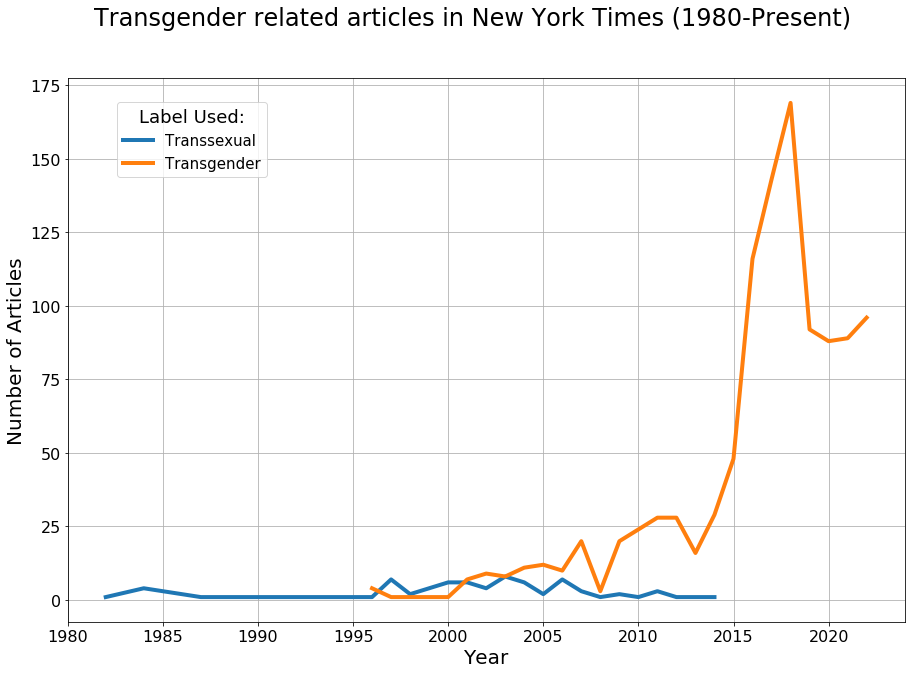

In [339]:
#PLOTS GRAPH 1
fig=plt.figure(figsize=(15,10))
plt.plot(ts,linewidth=4.0,label="Transsexual")
plt.plot(tg,linewidth=4.0, label="Transgender")

#Layout
fig.suptitle("Transgender related articles in New York Times (1980-Present)", fontsize=24)
plt.ylabel ("Number of Articles",fontsize=20)
plt.xlabel ("Year",fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left',fontsize='small',title="Label Used:",title_fontsize="18",
           bbox_to_anchor=(0.05, 0., 0, .97))
plt.grid()

#Save
plt.savefig('nytimes_trans_graph.png')
plt.show()


In [38]:
#splices database to compare two time periods: 2000-2005 and 2015-2020
nytimes_cat_2000_2005_db=nytimes_trans_db_cleaned.loc[(nytimes_trans_db_cleaned['Date']>='2000-01-01') &
                             (nytimes_trans_db_cleaned['Date']<'2005-01-01')]

nytimes_cat_2015_2020_db=nytimes_trans_db_cleaned.loc[(nytimes_trans_db_cleaned['Date']>='2015-01-01') &
                             (nytimes_trans_db_cleaned['Date']<'2021-01-01')]

In [39]:
#Groups two databases by Category
by_category_A_db=nytimes_cat_2000_2005_db.groupby(['Category']).count()
by_category_B_db=nytimes_cat_2015_2020_db.groupby(['Category']).count()

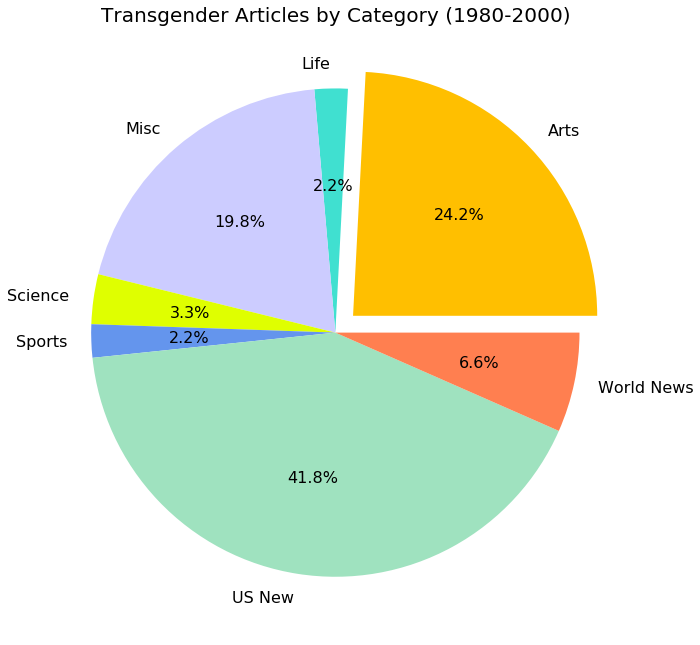

In [41]:
#Plot Category pie Chart
fig2=plt.figure(figsize=(10,10))

#Layout
plt.title('Transgender Articles by Category (1980-2000)', fontsize=20)
plt.rc('font', size=18)   
labels=['Arts', 'Life', 'Misc', 'Science', 'Sports',
       'US New',  'World News']
sizes=by_category_A_db['Headline']
colors=['#FFBF00','#40E0D0','#CCCCFF','#DFFF00','#6495ED','#9FE2BF','#FF7F50']
explode=(.1,0,0,0,0,0,0)


#Plot Graph
plt.pie(sizes,explode=explode,colors=colors,labels=labels,autopct='%1.1f%%',textprops={'fontsize': 16})
plt.tight_layout()

#Save
plt.savefig('nytimes_trans_category_pie_A.png')
plt.show()

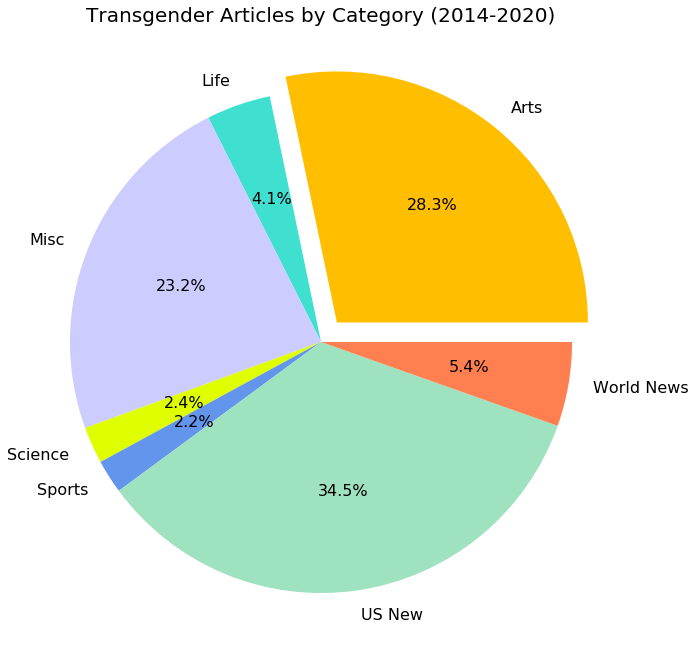

In [42]:
#Plot Category pie Chart
fig2=plt.figure(figsize=(10,10))

#Layout
plt.title('Transgender Articles by Category (2014-2020)', fontsize=20)
plt.rc('font', size=18)   
labels=labels=['Arts', 'Life', 'Misc', 'Science', 'Sports',
       'US New',  'World News']
sizes=by_category_B_db['Headline']
colors=['#FFBF00','#40E0D0','#CCCCFF','#DFFF00','#6495ED','#9FE2BF','#FF7F50']
explode=(.1,0,0,0,0,0,0)


#Plot Graph
plt.pie(sizes,explode=explode,colors=colors,labels=labels,autopct='%1.1f%%',textprops={'fontsize': 16})
plt.tight_layout()

#Save
plt.savefig('nytimes_trans_category_pie_B.png')
plt.show()